# D213 Task 1 Advanced Data Analytics

## Part 1

### A1: Research Question and Data Selection

Research Question:
Is it possible to at accurately determine customer sentiment from a customers review utilizing Natural language processing and nural networks?

Data and Rational:
The data that will be used for this analysis is "sentiment labeled sentences" dataset which can be found at the link bellow. This data set provides a sentence representing a review along with a label of 1 or 0 indicating a positive or negative sentiment respectively


https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

### A2: Objectives

The objective of this analysis is to determine the feasibility of using a natural language processing neural network to determine a customers sentiment based on a review. The determination of feasibility will be made by creating a NLP model using Tensorflow. The objective of this model is to be able to take in the review text data and determine if the review has a positive or negative sentiment. 

### A3: Neural Network Type

This analysis will utilize a recurrent neural network (RNN). This type of neural network is commonly used for text classification and sentiment analysis. This is due to the ability of a RNN model to maintain the state of sequential data where the order of the inputs is critical. This model will be developed using Tensorflow's Keras package which provides multiple RNN models out of the box.

## Part 2

### B1: Data Exploration and Cleaning

1. Check presence of unusual characters
2. Vocabulary size
3. proposed word embedding length
4. statistical justification for the chosen maximum sequence length



In [618]:
# Import Packages
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Download Stopwords early to avoid rerunning
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/orlandmalphrus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [619]:
# Extract data create combined dataframe and check counts
amazon_df = pd.read_csv('./data/amazon_cells_labelled.txt', sep='\t', names=['review', 'score'])
imdb_df = pd.read_csv('./data/imdb_labelled.txt', sep='\t', names=['review', 'score'])
yelp_df = pd.read_csv('./data/yelp_labelled.txt', sep='\t', names=['review', 'score'])

print(f'Amazon Count: {amazon_df.shape[0]}')
print(f'IMDB Count: {imdb_df.shape[0]}')
print(f'Yelp Count: {yelp_df.shape[0]}')

# Label Data Source
amazon_df['source'] = 'amz'
imdb_df['source'] = 'imdb'
yelp_df['source'] = 'yelp'

# Join Dataframes 
df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)
df.head()

Amazon Count: 1000
IMDB Count: 1000
Yelp Count: 1000


,review,score,source
0,So there is no way for me to plug it in here i...,0,amz
1,"Good case, Excellent value.",1,amz
2,Great for the jawbone.,1,amz
3,Tied to charger for conversations lasting more...,0,amz
4,The mic is great.,1,amz


In [620]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   score   3000 non-null   int64 
 2   source  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [621]:
# Get all Unique chars from the dataset 
# Convert all reviews to a single string and then to a set to get unique characters
unique_chars = set(''.join(df['review']))
print('All Unique Characters:')
print(unique_chars)

All Unique Characters:
{'å', 'Z', 'E', 'c', 'o', 'C', '(', 'U', 'Q', 'X', 'V', 'Y', '-', 'a', '1', 'K', 'G', 'b', "'", 'M', 'N', 'f', 's', 'm', 'y', ':', '.', ',', 'S', 'j', '6', 'r', 'u', '*', '2', 'R', 'z', 'w', 'I', 'L', 'B', 'F', '\x97', 'k', 'T', 'W', '\x85', 'n', 'H', 'D', ']', '5', 'x', 'i', 'd', '8', 'e', ')', 'P', 'J', '/', '3', 't', '\x96', 'é', 'h', 'g', '$', ';', 'l', 'q', '!', 'O', '7', '+', '0', '"', '?', '[', ' ', '%', '9', '#', '4', 'v', 'ê', 'p', 'A', '&'}


In [622]:
non_alpha_numeric_chars = [char for char in unique_chars if not char.isalnum()]
print('Non alpha numeric characters:')
print(non_alpha_numeric_chars)

Non alpha numeric characters:
['(', '-', "'", ':', '.', ',', '*', '\x97', '\x85', ']', ')', '/', '\x96', '$', ';', '!', '+', '"', '?', '[', ' ', '%', '#', '&']


In [623]:
# Remove non-alphanumeric chars
df['cleaned_review'] = df['review'].apply(lambda x: ''.join([char for char in x if char.isalnum() or char.isspace()]))
# Remove stopwords
df['cleaned_reduced_review'] = df['cleaned_review'].apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop_words]))

df.head()

,review,score,source,cleaned_review,cleaned_reduced_review
0,So there is no way for me to plug it in here i...,0,amz,So there is no way for me to plug it in here i...,way plug us unless go converter
1,"Good case, Excellent value.",1,amz,Good case Excellent value,good case excellent value
2,Great for the jawbone.,1,amz,Great for the jawbone,great jawbone
3,Tied to charger for conversations lasting more...,0,amz,Tied to charger for conversations lasting more...,tied charger conversations lasting 45 minutesm...
4,The mic is great.,1,amz,The mic is great,mic great


In [624]:
# Vocabulary Size
all_words = ' '.join(df['cleaned_reduced_review']).lower().split()
vocabulary = set(all_words)
vocabulary_size =  len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 5276


In [625]:
# Proposed word embedding length. Based on an industry rule of thumb for embeddings taking a forth root (Goldman, 2019)
proposed_embedding_length = round(vocabulary_size ** .25)
print(f"Proposed embedding length: {proposed_embedding_length}")

Proposed embedding length: 9


In [626]:
# Justification of max sequence length
df['cleaned_review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
clean_review_length_mean = df['cleaned_review_length'].mean()
clean_review_length_std = df['cleaned_review_length'].std()
clean_review_length_max = df['cleaned_review_length'].max()

print(f"Mean clean_review_length: {clean_review_length_mean}")
print(f"Standard deviation of clean_review_length: {clean_review_length_std}")
print(f"Maximum clean_review_length: {clean_review_length_max}")

# max length that covers around 95% of the dataset
cutoff_length = int(clean_review_length_mean + 2 * clean_review_length_std)
print(f"Suggested max sequence length: {cutoff_length}")


Mean clean_review_length: 11.777666666666667
Standard deviation of clean_review_length: 7.8309221893934255
Maximum clean_review_length: 70
Suggested max sequence length: 27


In [627]:
# Test train split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

### B2: Tokenization

The goal of tokenization is to break down words or groups of words into numerical representations that are easily consumed by machines. The tokenizer this analysis employees is from the tensorflow keras library. The output of the tokenization process is an array of integers that can be used for further analysis.

In [628]:
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(train_df['cleaned_reduced_review'])
train_df['tokens'] = tokenizer.texts_to_sequences(train_df['cleaned_reduced_review'])
test_df['tokens'] = tokenizer.texts_to_sequences(test_df['cleaned_reduced_review'])

In [629]:
train_df[['cleaned_reduced_review' ,'tokens', 'score']]

,cleaned_reduced_review,tokens,score
2369,deserves 5 stars,"[617, 180, 181]",1
1164,good thing tickets cost five dollars would mad...,"[2, 56, 1791, 618, 619, 1119, 16, 1792, 233, 6...",0
477,volume switch rocketed unit destination unknown,"[259, 1794, 1795, 328, 1796, 1797]",0
1728,nice relaxing late night viewing,"[30, 1798, 1120, 142, 1121]",1
1065,one character totally annoying voice gives fee...,"[7, 126, 114, 508, 329, 621, 203, 1799, 1800]",0
...,...,...,...
2514,everything perfect night,"[67, 198, 142]",1
2347,classywarm atmosphere fun fresh appetizers suc...,"[4612, 374, 273, 153, 1726, 4613, 738, 4614, 169]",1
1608,accents absolutely abysmal,"[4615, 137, 4616]",0
2541,waited thirty minutes seated although 8 vacant...,"[365, 4617, 83, 759, 394, 611, 4618, 598, 629,...",0


In [630]:
test_df[['cleaned_reduced_review' ,'tokens', 'score']]

,cleaned_reduced_review,tokens,score
1291,rating 1 10,"[625, 225, 132]",0
595,possesed get junk idea,"[1, 35, 562, 1012]",0
236,best bluetooth market,"[22, 229, 898]",1
2824,awful service,"[149, 13]",0
1290,camerawork bad,"[2909, 14]",0
...,...,...,...
2236,descriptions said yum yum sauce another said e...,"[1, 212, 1, 1, 420, 154, 212, 1, 420, 352, 154...",0
1448,810 score mostly plot,"[1, 4472, 510, 87]",1
1189,excellent performance ms,"[39, 204, 4321]",1
8,needless say wasted money,"[1266, 58, 409, 89]",0


### B3: Padding Process

The padding process takes advantage of the Keras `pad_sequences` function. This function takes in an array of tokens and applies padding. Padding is necessary to ensure the machine has inputs of the same shape(length). By setting `padding` and `truncating` to 'post' the function will ensure that padding or truncation is applied to the end of the sequence. By setting `maxlen` to the cutoff established earlier in this analysis (27) the function will truncate records to this length. This introduces a serious tradeoff between the potential loss of information and computational efficiency. With this in mind this analysis uses a cutoff that is equal to two times the standard deviation sequence length. This should ensure that 95% the data is preserved while avoiding excessive padding.

In [631]:
print(f'Cutoff: {cutoff_length}')

Cutoff: 27


In [632]:
train_df['padded_tokens'] = list(pad_sequences(train_df['tokens'].tolist(), padding='post', maxlen=cutoff_length, truncating='post'))
test_df['padded_tokens'] = list(pad_sequences(test_df['tokens'].tolist(), padding='post', maxlen=cutoff_length, truncating='post'))

test_df[['padded_tokens' ,'tokens', 'score']].head()

,padded_tokens,tokens,score
1291,"[625, 225, 132, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[625, 225, 132]",0
595,"[1, 35, 562, 1012, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 35, 562, 1012]",0
236,"[22, 229, 898, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[22, 229, 898]",1
2824,"[149, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[149, 13]",0
1290,"[2909, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2909, 14]",0


In [633]:
train_df[['padded_tokens' ,'tokens', 'score']].head()

,padded_tokens,tokens,score
2369,"[617, 180, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[617, 180, 181]",1
1164,"[2, 56, 1791, 618, 619, 1119, 16, 1792, 233, 6...","[2, 56, 1791, 618, 619, 1119, 16, 1792, 233, 6...",0
477,"[259, 1794, 1795, 328, 1796, 1797, 0, 0, 0, 0,...","[259, 1794, 1795, 328, 1796, 1797]",0
1728,"[30, 1798, 1120, 142, 1121, 0, 0, 0, 0, 0, 0, ...","[30, 1798, 1120, 142, 1121]",1
1065,"[7, 126, 114, 508, 329, 621, 203, 1799, 1800, ...","[7, 126, 114, 508, 329, 621, 203, 1799, 1800]",0


In [634]:
# Printing one example of a padded token array

print(train_df['padded_tokens'][0].tolist())

[44, 301, 98, 446, 25, 3566, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [635]:
# Simplify split for easy programmatic access
X_train = np.array([x.flatten() for x in train_df['padded_tokens'].tolist()])
y_train = train_df['score'].values
X_test = np.array([x.flatten() for x in test_df['padded_tokens'].tolist()])
y_test = test_df['score'].values

### B4: Categories of Sentiment

There are two categories of sentiment in this analysis `positive` represented by 1 and `negative` represented by 0. Due to the binary nature of target categories a sigmoid activation function will be used in this analysis. The sigmoid function will output a value between 0 and 1 which will represent the probability of a review is positive and therefore the inverse will show the probability the review is negative. 

### B5: Data Preparation Steps

1. **Loading of Tools and Stopwords**: At the beginning of this analysis we load all needed tools. Loading of stopwords is included in tool import as it contains time-consuming network activity.
2.  **Data loading**: The yelp, imdb and amazon data is loaded from tab separated files. These three datasets provide the reviews for the sentiment analysis.
3. **Join Data Sources and Review Counts**: To ensure the data loaded properly counts are examined for each of the three datasets. After confirming that the counts match the datasets are joined into one main dataframe `df`.
4. **Data Summary**: Data info summery is produced using pandas dataframe builtin info method.
5. **Handling of unusual characters and punctuation**: A set is produced containing all unique characters within the dataset. The presence of non-standard characters was confirmed by visualizing the character set. Non-standard characters were removed along with all punctuation by only retaining alphanumeric characters. This reduces potential complexity, and potential noise from the analysis.
6. **Removal of Stopwords**: Stopwords are removed using NLTK's set of words that are so commonly used that there presence is unlikely to add value to the analysis.
7. **Vocabulary Size Determination**:  The vocabulary size is determined by taking the count of unique words present in the cleaned reduced review set.
8. **Word Embedding Length Determination**: The word embedding length was determined using an industry rule of thumb by taking a forth root of the vocabulary size(Goldman, 2019).
9. **Max sequence length Determination**: The max sequence length was determined by using statistical measures to produce a cutoff that would preserve 95% of the dataset while still providing a reasonable cutoff.
10. **Splitting test and train data**: The dataset was then split into a training data set that consisted of 80% of the records and a test set consisting of the remaining 20%. Sklearn provided the train_test_split function that was used in this process.
11. **Tokenization**: Tokenization was applied using a Keras tokenizer. This transformed the textual review data to an array of integers representing the text data.
12. **Padding**: Padding was added to the token array to produce token arrays of the same length. A more detailed review of this process is available in section B3.
13. **Data Export** In the following the full dataset will be exported to CSV along with the test and train clean dataframes. This will be done using pandas builtin to_csv method.


### B6: Cleaned Data Set

Attached to submission

In [636]:
df.to_csv('./full_data_set.csv')
test_df.to_csv('./test_data_set.csv')
train_df.to_csv('./train_data_set.csv')

## Part 3: Network Architecture

### C1: Output of Model Summary

In [637]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=proposed_embedding_length, input_length = cutoff_length, mask_zero=True))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [638]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 27, 9)             47484     
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 64)                4736      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 52285 (204.24 KB)
Trainable params: 52285 (204.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### C2: Layer Descriptions

This model contains three layers an embedding layer, a simple RNN layer and a Dense output layer. The total number of parameters is 52,285 all of which are trainable. A breakdown of the layers and their parameters is bellow.

**Embedding Layer**: The embedding layer serves to convert the integer encoded textual data into dense vectors that the remainder of the network can consume. It does this taking into consideration the previously determined cutoff value, vocabulary length and embedding dimensionality. This layer accounts for 47,484 parameters.

**RNN Layer (Simple RNN)**  SimpleRNN is a basic recurrent neural network which allows for the capture patterns in the order of data in the review sequence. This layer accounts for 4736 parameters.

**Dense Layer (output / activation)**: The final layer in the model is a dense layer that applies a sigmoid activation function. This layer is the output layer. This layer accounts for 65 parameters.


### C3: Hyperparameter Justification

**Activation function**: Due to the binary nature of this classification this analysis will use a sigmoid function as the activation layer. The sigmoid function will return a value between one and zero which will represent the probability that the sentiment is positive. 

**Nodes per Layer**:
- Embedding dimension: the embedding layer does not contain a specified number of nodes but represents the total vocabulary as 9 dimensional vectors.
- RNN Layer: The RNN layer has 64 nodes. Traditional start values in this type of analysis are 32, 64, or 128. 64 was chosen here to compensate for the low dimensionality within the embedding layer as it is larger than the base of 32. 64 was a better start than 128 as the scope of the vocabulary was not large enough to demand that level of compensation. The model preformed well with 64 nodes so this value was not modified.
- Dense Layer (Activation): The final layer contains 1 node. Due to the binary nature of this problem a single node is appropriate for the output layer. 

**Loss Function**: Since this sentiment analysis is binary in nature with either a positive or negative sentiment Binary Crossentropy is the appropriate choice. Binary Crossentropy measures distance between the label and the predicted value which is ideal for this analysis.

**Optimizer**: Adam is used in this analysis as it is a highly adaptive optimization algorithm. Adam is often applied as default optimizer and due to the strait forward nature of this analysis there is no current need to find a more specialized solution.

**Stopping Criteria**: EarlyStopping is used in this analysis to prevent over fitting of the model. Early Stopping allows the model to stop evaluating when performance degrades. This saves computational resources and training time.

**Evaluation Metric**: The binary nature of this analysis makes Accuracy the ideal metric to evaluate this model on. Accuracy is an easily interpretable metric that is easily translatable to business value. 

## Part 4

### D1: Stopping criteria

Utilizing a stopping criteria is critical to prevent over fitting. Bellow we see that using early stopping the model did not need to utilize all 10 epochs that it were defined. This eliminates the need for unnecessary training cycles. The final epoch can be visualized bellow as the last printed Epoch.

In [639]:
training_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks = EarlyStopping())

Epoch 1/10
75/75 [==============================] - 1s 5ms/step - loss: 0.6885 - accuracy: 0.5500 - val_loss: 0.6645 - val_accuracy: 0.6733
Epoch 2/10
75/75 [==============================] - 0s 3ms/step - loss: 0.5227 - accuracy: 0.8008 - val_loss: 0.5509 - val_accuracy: 0.7350
Epoch 3/10
75/75 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.9196 - val_loss: 0.5343 - val_accuracy: 0.7817
Epoch 4/10
75/75 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.9671 - val_loss: 0.6361 - val_accuracy: 0.7767


### D2: Visualizations of training process

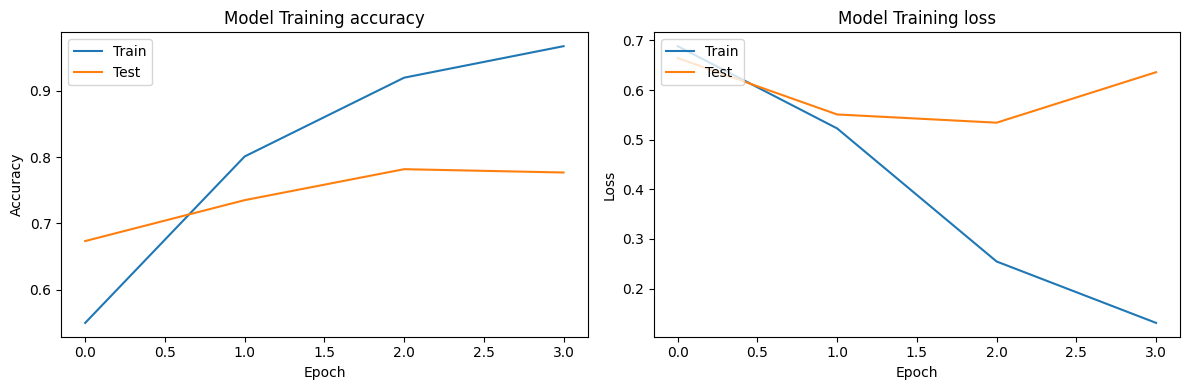

In [640]:
plt.figure(figsize=(12, 4))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [641]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

19/19 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.7767
Accuracy: 77.67%


### D3: Fit Evaluation

Over the course of the Epochs the models accuracy improved for both the test and training set indicating that effective learning was occurring. There are however signs of over fitting as the test accuracy begins to level out as the training accuracy increases consistently. Early stopping is used to mitigate this over fitting. Initially the early stopping had a patience of 2. After visualizing more severe signs of over fitting this was removed to stop even earlier in the training process.



### D4: Accuracy

The accuracy of the trained model is consistently above 75% on the test data. This indicates that the produced model has 75% chance of classifying sentiment accurately. This is a significant accuracy rate that has the potential to deliver significant business value.

## Part 5

### E: Code 

provided above


### F: Functionality

Above code runs without error or warning

### G: Recommendations

The utilization of NLP and Nural Networks in predicting review sentiment has been proven effective in this analysis. With the context of this study it is recommended to continue further analysis and development of this base model. While the accuracy of this model could have immediate utility the model could potentially be more effective with additional experimentation. Experimentation with additional model layers and different tokenizers may prove effective at improving overall accuracy. 

The business recommendation would be to begin utilizing the existing model in the interim while further analysis is done. While accuracy may be improved in the future an accuracy of 75% or greater is effective enough to use in a reporting capacity. By classifying positive and negative reviews of products further analysis can be dont on the individual products with the highest count of negative reviews. 

### H: Reporting

Jupyter Notebook

### J: Sources

Goldman, Sally. “Embeddings  |  Machine Learning Crash Course  |  Google Developers.” Google Developers, 2019, developers.google.com/machine-learning/crash-course/embeddings/video-lecture. Accessed 24 Sept. 2023.
